In [1]:
from text2sql_lib.benchmark import run_benchmark

run_benchmark(
    dataset_path="./synthetic_text_to_sql/cached_test.parquet",
    log_path="benchmark_results.jsonl",
    model_name="qwen2.5:latest",
    max_examples=50,
    gpu_monitor_interval=1.0,
    monitor_gpu=True
)

Benchmarking: 100%|██████████| 50/50 [02:53<00:00,  3.48s/it]


In [ ]:
import json

LOG_PATH = "benchmark_results.jsonl"

def find_llm_true_others_false(log_path):
    with open(log_path, "r") as f:
        lines = f.readlines()

    filtered = []
    for line in lines:
        entry = json.loads(line)
        if (
            entry.get("llm_equivalent") is True and
            entry.get("match_exact") is False and
            entry.get("match_ast") is False
        ):
            filtered.append(entry)

    print(f"Found {len(filtered)} cases where LLM judged True but exact and AST are False.\n")

    for i, entry in enumerate(filtered, 1):
        print(f"--- Case #{i} ---")
        print(f"Example ID: {entry['example_id']}")
        print(f"Prompt:\n{entry['prompt']}\n")
        print(f"Reference SQL:\n{entry['reference_sql']}\n")
        print(f"Generated SQL:\n{entry['generated_sql']}\n")
        print(f"LLM Explanation:\n{entry['llm_explanation']}\n")
        print("="*60)

if __name__ == "__main__":
    find_llm_true_others_false(LOG_PATH)


In [3]:
from text2sql_lib.visualize import visualize_benchmark_results, visualize_benchmark_results2

# visualize_benchmark_results("benchmark_results.jsonl")

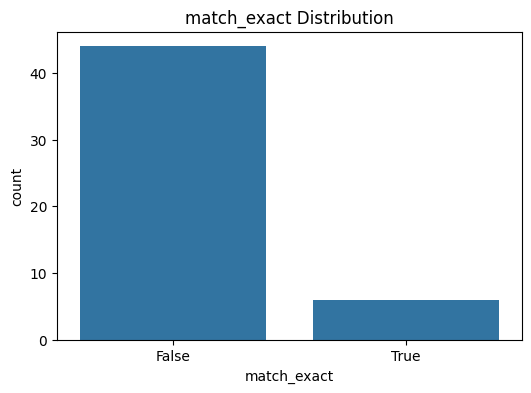

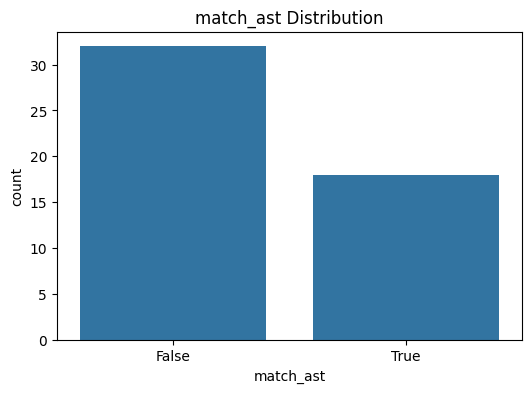

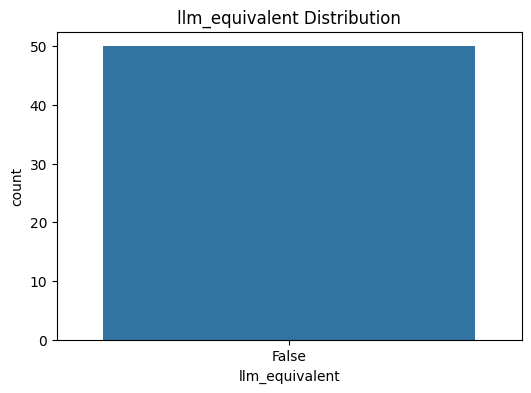

match_exact       0.12
match_ast         0.36
llm_equivalent    0.00
dtype: float64


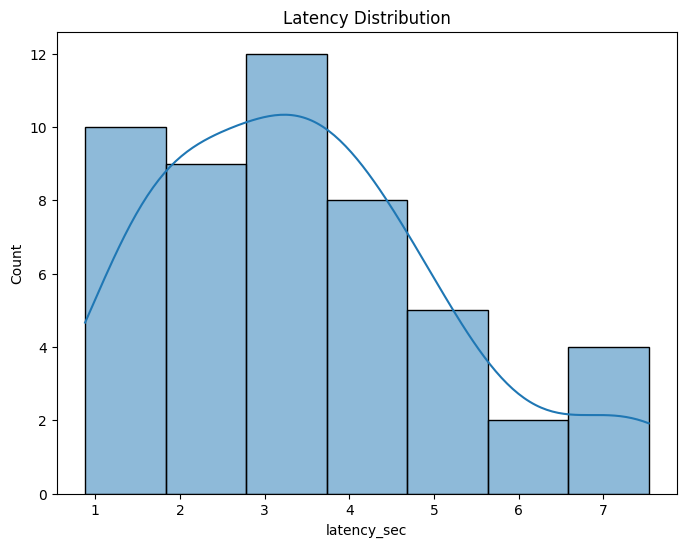

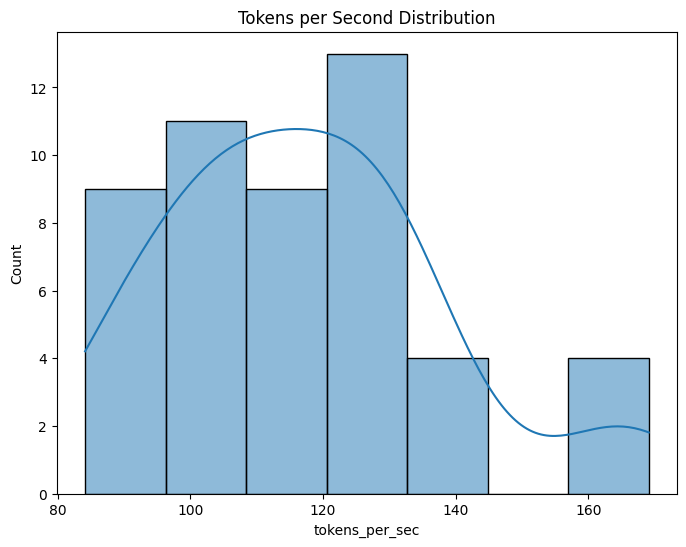

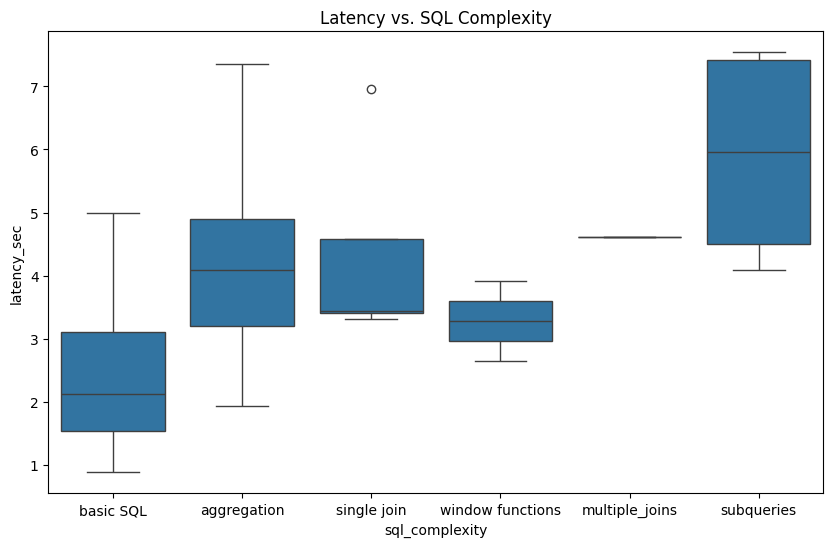

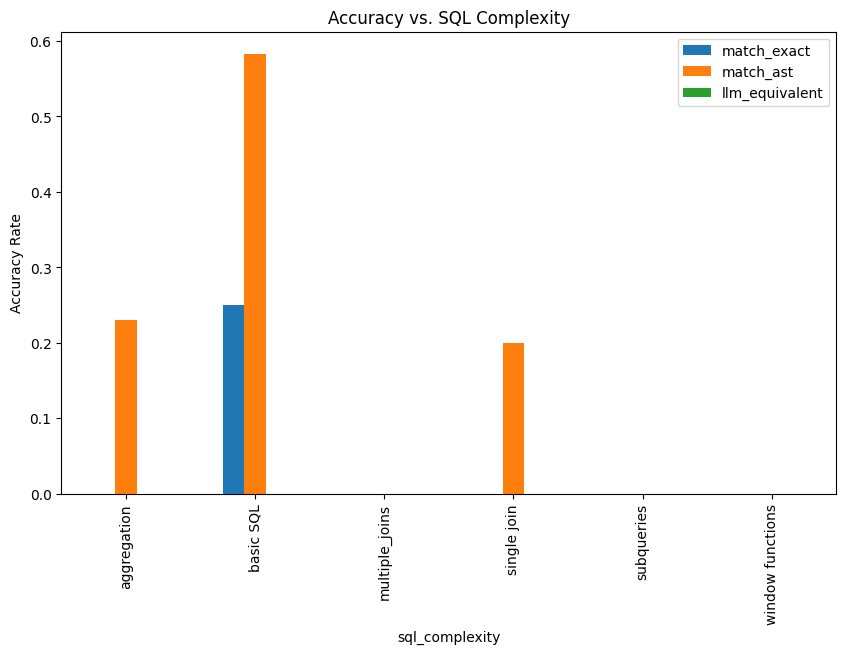

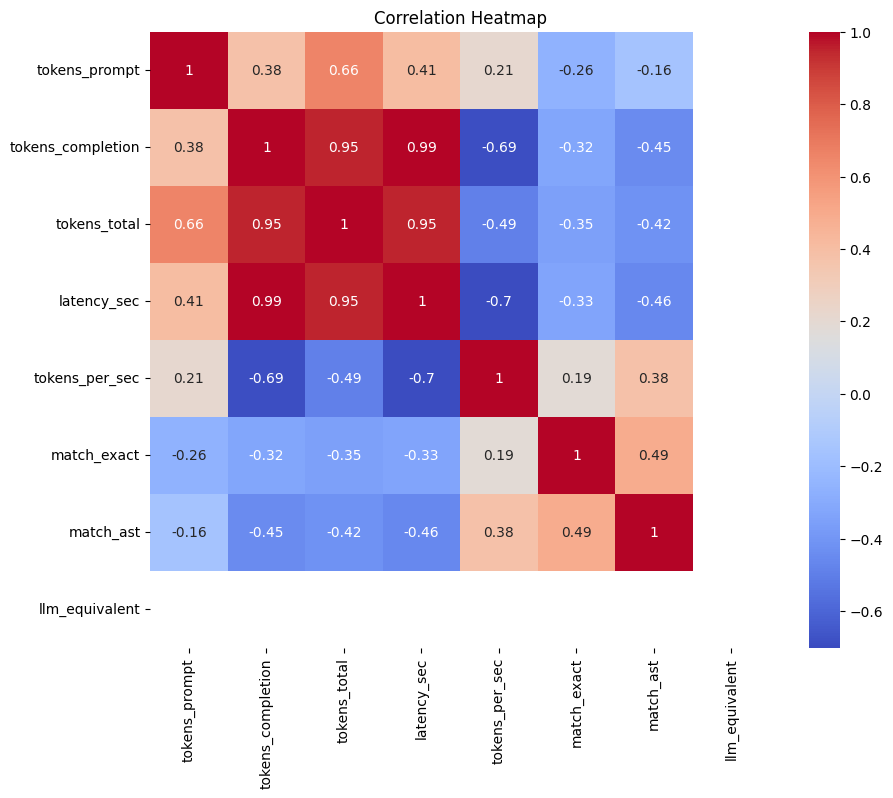

In [4]:
visualize_benchmark_results2("benchmark_results.jsonl")

In [ ]:
visualize_benchmark_results2("benchmark_results.jsonl")

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Path to your GPU monitoring JSON file
gpu_log_path = "benchmark_results_gpu_timeseries.json"

# Load GPU monitoring data
with open(gpu_log_path, "r") as f:
    gpu_samples = json.load(f)

# Convert list of dicts into DataFrame
df = pd.DataFrame(gpu_samples)

# Parse timestamp string into datetime objects
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Optional: Sort by timestamp just in case
df = df.sort_values("timestamp")

# Select some key metrics to plot
metrics = [
    "temperature_c",
    "gpu_util_percent",
    "power_w",
    "vram_used_mb",
]

# Plot each metric for each GPU index
gpu_indices = df["gpu_index"].unique()

fig, axs = plt.subplots(len(metrics), 1, figsize=(12, 3 * len(metrics)), sharex=True)

for i, metric in enumerate(metrics):
    ax = axs[i]

    for gpu_id in gpu_indices:
        gpu_data = df[df["gpu_index"] == gpu_id]
        ax.plot(gpu_data["timestamp"], gpu_data[metric])

    ax.set_ylabel(metric.replace("_", " ").title())
    ax.legend()
    ax.grid(True)

# Formatting the x-axis for better date-time readability
axs[-1].set_xlabel("Timestamp")
axs[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.xticks(rotation=30)

plt.tight_layout()
plt.show()
